In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import os 
import numpy as np

In [3]:
# Configuration
DATASET_PATH = 'data'
BATCH_SIZE = 32
IMG_SIZE = (128, 128)
LATENT_DIM = 100
EPOCHS = 200

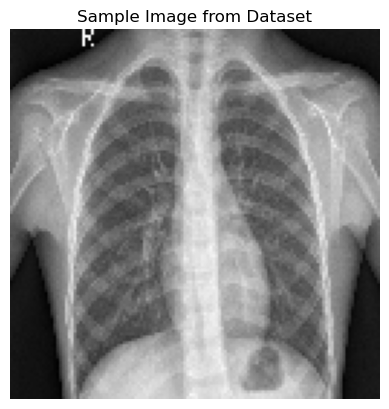

In [5]:
# Display sample image from dataset
sample_image_path = next(iter(tf.io.gfile.glob(os.path.join(DATASET_PATH, "*.jpeg"))))
image = tf.io.read_file(sample_image_path)
image = tf.image.decode_jpeg(image, channels=1)
image = tf.image.resize(image, (128, 128))
plt.imshow(image.numpy().squeeze(), cmap="gray")
plt.axis("off")
plt.title("Sample Image from Dataset")
plt.show()

In [4]:
# Data preprocessing function
def load_and_preprocess_image(file_path):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=1)
    image = tf.image.resize(image, IMG_SIZE)
    image = tf.cast(image, tf.float32) / 255.0  # [0, 1]
    image = (image - 0.5) * 2.0                 # [-1, 1]
    return image

In [5]:
# Create dataset pipeline
train_dataset = tf.data.Dataset.list_files(os.path.join(DATASET_PATH, '*.jpeg'), shuffle=True)
train_dataset = train_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [6]:
# Data augmentation
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.1),
])

In [7]:
# Generator model
def build_generator():
    model = keras.Sequential([
        layers.Dense(8*8*512, input_dim=LATENT_DIM),
        layers.Reshape((8, 8, 512)),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),
        layers.Conv2DTranspose(256, (4,4), strides=2, padding='same'),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),
        layers.Conv2DTranspose(128, (4,4), strides=2, padding='same'),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),
        layers.Conv2DTranspose(64, (4,4), strides=2, padding='same'),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),
        layers.Conv2DTranspose(32, (4,4), strides=2, padding='same'),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),
        layers.Conv2DTranspose(1, (4,4), padding='same', activation='tanh')
    ])
    return model

In [8]:
# Discriminator model
def build_discriminator():
    model = keras.Sequential([
        layers.InputLayer(input_shape=(128, 128, 1)),
        data_augmentation,
        layers.Conv2D(64, (4,4), strides=2, padding='same'),
        layers.LeakyReLU(0.2),
        layers.Conv2D(128, (4,4), strides=2, padding='same'),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),
        layers.Conv2D(256, (4,4), strides=2, padding='same'),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),
        layers.Conv2D(512, (4,4), strides=2, padding='same'),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

In [9]:
# Build and compile models
generator = build_generator()
discriminator = build_discriminator()
gen_optimizer = keras.optimizers.Adam(0.0002, beta_1=0.5)
disc_optimizer = keras.optimizers.Adam(0.0001, beta_1=0.5)
cross_entropy = keras.losses.BinaryCrossentropy()

C:\Users\gscke\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\gscke\anaconda3\Lib\site-packages\keras\src\layers\core\input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [10]:
# Training step
def train_step(real_images):
    noise = tf.random.normal([BATCH_SIZE, LATENT_DIM])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        fake_images = generator(noise, training=True)
        real_output = discriminator(real_images, training=True)
        fake_output = discriminator(fake_images, training=True)
        
        real_loss = cross_entropy(tf.ones_like(real_output), real_output)
        fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
        disc_loss = (real_loss + fake_loss) / 2
        gen_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
    
    disc_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    gen_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
    disc_optimizer.apply_gradients(zip(disc_gradients, discriminator.trainable_variables))
    gen_optimizer.apply_gradients(zip(gen_gradients, generator.trainable_variables))
    return disc_loss, gen_loss

In [11]:
# Training loop with loss tracking
def train(dataset, epochs):
    d_losses = []
    g_losses = []
    for epoch in range(epochs):
        total_d_loss = 0.0
        total_g_loss = 0.0
        num_batches = 0
        for batch in dataset:
            disc_loss, gen_loss = train_step(batch)
            total_d_loss += disc_loss
            total_g_loss += gen_loss
            num_batches += 1
        
        avg_d_loss = total_d_loss / num_batches
        avg_g_loss = total_g_loss / num_batches
        d_losses.append(avg_d_loss.numpy())
        g_losses.append(avg_g_loss.numpy())
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}, D Loss: {avg_d_loss:.4f}, G Loss: {avg_g_loss:.4f}")
            generate_and_save_images(generator, epoch + 1)
    
    generator.save('generator_model.h5')
    return d_losses, g_losses

In [12]:
# Image generation during training
def generate_and_save_images(model, epoch):
    predictions = model(tf.random.normal([16, LATENT_DIM]), training=False)
    plt.figure(figsize=(4,4))
    for i in range(16):
        plt.subplot(4,4,i+1)
        plt.imshow(predictions[i,:,:,0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
    plt.savefig(f'image_epoch_{epoch:04d}.png')
    plt.close()

In [13]:
# Execute training
d_losses, g_losses = train(train_dataset, EPOCHS) 

Epoch 10, D Loss: 0.4277, G Loss: 2.0094
Epoch 20, D Loss: 0.5740, G Loss: 1.4403
Epoch 30, D Loss: 0.5752, G Loss: 1.4632
Epoch 40, D Loss: 0.5326, G Loss: 1.4205
Epoch 50, D Loss: 0.5486, G Loss: 1.4186
Epoch 60, D Loss: 0.5972, G Loss: 1.4086
Epoch 70, D Loss: 0.5642, G Loss: 1.3938
Epoch 80, D Loss: 0.5645, G Loss: 1.2889
Epoch 90, D Loss: 0.6188, G Loss: 1.2152
Epoch 100, D Loss: 0.5647, G Loss: 1.2569
Epoch 110, D Loss: 0.5840, G Loss: 1.2858
Epoch 120, D Loss: 0.6386, G Loss: 1.1466
Epoch 130, D Loss: 0.6329, G Loss: 1.1394
Epoch 140, D Loss: 0.5965, G Loss: 1.2600
Epoch 150, D Loss: 0.6499, G Loss: 1.2010
Epoch 160, D Loss: 0.6487, G Loss: 1.0921
Epoch 170, D Loss: 0.6031, G Loss: 1.1575
Epoch 180, D Loss: 0.6267, G Loss: 1.1355
Epoch 190, D Loss: 0.6217, G Loss: 1.1037
Epoch 200, D Loss: 0.6309, G Loss: 1.1282


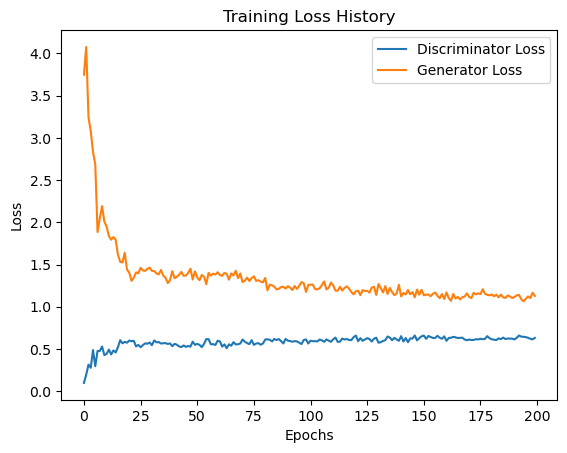

In [14]:
# Plot loss curves
plt.figure()
plt.plot(d_losses, label='Discriminator Loss')
plt.plot(g_losses, label='Generator Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss History')
plt.savefig('loss_curves.png')
plt.show()

In [15]:
 generator.save('generator_model.keras')

In [ ]:
# Function to load trained generator
def load_trained_generator(model_path='generator_model.keras'):
    return keras.models.load_model(model_path, compile=False)

In [ ]:
# Example usage
loaded_generator = load_trained_generator()

In [ ]:
# Generate new images using the loaded model
new_images = loaded_generator(tf.random.normal([16, LATENT_DIM]))

NameError: name 'LATENT_DIM' is not defined

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

def generate_images_grid(model_path, latent_dim=100):
   
    # Load the trained generator model
    generator = tf.keras.models.load_model(model_path)

    # Generate a batch of 16 random latent vectors
    random_latent_vectors = np.random.normal(0, 1, (16, latent_dim))

    # Generate images
    generated_images = generator.predict(random_latent_vectors)

    # Rescale pixel values (assuming generator outputs [-1, 1] range)
    generated_images = (generated_images + 1) / 2.0

    # Plot the images in a 4x4 grid
    fig, axes = plt.subplots(4, 4, figsize=(8, 8))
    for i, ax in enumerate(axes.flat):
        ax.imshow(generated_images[i].squeeze(), cmap="gray")  # Adjust for RGB if needed
        ax.axis("off")

    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 692ms/step


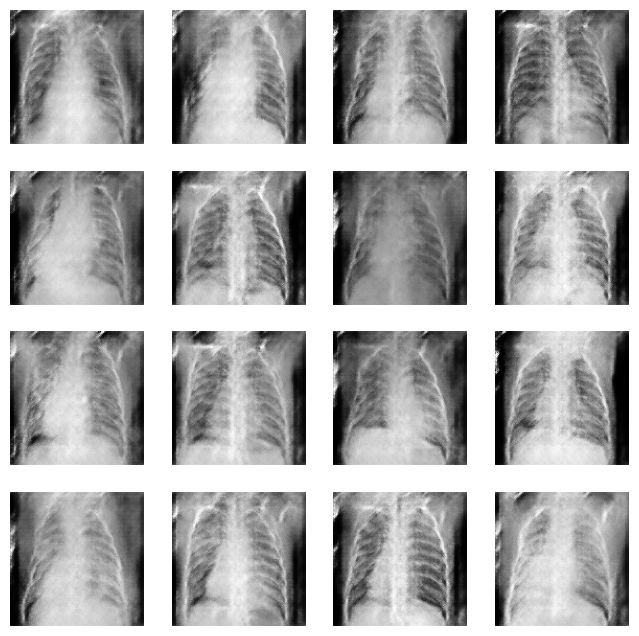

In [ ]:
generate_images_grid("generator_model.keras")
